# Regression logistique sur echonest

**[WARNING]:** *Do not forget to run the `setup.py`script, and to choose the correct virtual environment for this notebook*  

In [2]:
import pandas as pd
echonest = pd.read_csv('data/fma_metadata/echonest.csv')

In [3]:
echonest = echonest.iloc[:,:9]

In [4]:
new_columns = echonest.iloc[1]
echonest.columns = new_columns
new_columns.iloc[0] = 'track_id' 
echonest = echonest.iloc[3:].reset_index(drop=True)

echonest

1,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715
...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274


In [5]:
tracks = pd.read_csv('data/fma_metadata/tracks.csv')
tracks.rename(columns={'Unnamed: 0':'track_id'},inplace=True)

train = tracks['set'] == 'training'
val = tracks['set'] == 'validation'
test = tracks['set']== 'test'

In [6]:
label = tracks[['track_id','track.7','set']]
label.rename(columns={'track.7':'genre_top'},inplace=True)
label = label[2:]

label

/tmp/ipykernel_43682/1089924658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.rename(columns={'track.7':'genre_top'},inplace=True)


,track_id,genre_top,set
2,2,Hip-Hop,training
3,3,Hip-Hop,training
4,5,Hip-Hop,training
5,10,Pop,training
6,20,NaN,training
...,...,...,...
106571,155316,Rock,training
106572,155317,Rock,training
106573,155318,Rock,training
106574,155319,Rock,training


In [37]:
full_set = pd.merge(echonest,label,how='inner',on='track_id')
full_set

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,set
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,Hip-Hop,training
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,Hip-Hop,training
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,Hip-Hop,training
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,Pop,training
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,Hip-Hop,training
...,...,...,...,...,...,...,...,...,...,...,...
10887,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461,NaN,training
10888,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,training
10889,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,training
10890,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,training


In [38]:
from collections import Counter

counts = Counter(full_set['genre_top'])
rare_classes = [cls for cls, c in counts.items() if c < 50]

full_set["genre_top_grouped"] = full_set["genre_top"].replace(
    {cls: "Other" for cls in rare_classes}
)

full_set

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,set,genre_top_grouped
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,Hip-Hop,training,Hip-Hop
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,Hip-Hop,training,Hip-Hop
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,Hip-Hop,training,Hip-Hop
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,Pop,training,Pop
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,Hip-Hop,training,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...
10887,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461,NaN,training,NaN
10888,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,training,NaN
10889,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,training,NaN
10890,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,training,NaN


In [41]:
from sklearn.model_selection import train_test_split

full_set.dropna(inplace=True)

X = full_set.drop(columns=['genre_top', 'genre_top_grouped', 'set', 'track_id'])
y = full_set["genre_top_grouped"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [32]:
train = full_set[full_set['set'] == 'training']
test = full_set[full_set['set'] == 'test']
train.dropna(inplace=True)
test.dropna(inplace=True)

print(train.size,test.size,test.size*100/train.size)

76032 8412 11.063762626262626


/tmp/ipykernel_43682/4174452763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_43682/4174452763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)


In [33]:
X_train = train.drop(columns=['genre_top', 'genre_top_grouped', 'set', 'track_id'])
y_train = train['genre_top_grouped']

X_test  = test.drop(columns=['genre_top', 'genre_top_grouped','set', 'track_id'])
y_test  = test['genre_top_grouped']

In [55]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

scaler = StandardScaler()
model = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=500)

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("clf", model)
])

param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10],
    "clf__penalty": ["l2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best macro-F1:", grid.best_score_)

Best params: {'clf__C': 10, 'clf__penalty': 'l2'}
Best macro-F1: 0.31092956190743437


In [56]:
y_pred = grid.predict(X_test)

In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

                     precision    recall  f1-score   support

          Classical       0.39      0.95      0.55        40
         Electronic       0.61      0.55      0.58       350
               Folk       0.39      0.21      0.28       159
            Hip-Hop       0.50      0.53      0.51       152
       Instrumental       0.02      0.07      0.03        14
      International       0.09      0.43      0.15        23
               Jazz       0.05      0.14      0.07        37
Old-Time / Historic       0.34      0.67      0.45        24
              Other       0.06      0.31      0.10        13
                Pop       0.12      0.24      0.16        59
               Rock       0.85      0.49      0.62       688

           accuracy                           0.47      1559
          macro avg       0.31      0.42      0.32      1559
       weighted avg       0.62      0.47      0.52      1559



In [58]:
# Si tu as réduit les features ou scalé, utilise les noms originaux
feature_names = X_train.columns

# Coefficients pour chaque classe
log_reg = grid.best_estimator_.named_steps["clf"]

coef_df = pd.DataFrame(log_reg.coef_, columns=feature_names, index=log_reg.classes_)
coef_df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
Classical,7.202307,-1.111403,-4.146146,0.331536,0.028492,-0.223577,-0.063362,0.202061
Electronic,-1.977461,0.727270,1.028227,0.575556,-0.036654,0.315360,0.098827,-0.588287
Folk,-0.555372,-0.192695,-0.112308,0.029871,-0.196729,-0.259489,-0.002665,-0.090815
Hip-Hop,-1.750070,0.753373,0.979121,-0.390583,0.029534,0.704109,-0.134977,-0.096810
Instrumental,-1.056943,0.317102,0.742292,-0.042860,0.092593,-0.204884,0.030217,-0.460958
International,-0.097971,-0.058807,0.443014,-0.075755,0.461233,0.194524,0.011523,0.735781
Jazz,-0.921728,-0.672832,0.190162,0.246659,-0.204460,0.298520,-0.174872,-0.171153
Old-Time / Historic,2.863695,0.370358,-1.191349,-0.161525,0.839148,0.076032,0.048096,0.782208
Other,-0.991596,-0.216097,0.006411,-0.214695,-0.721961,0.092177,-0.135999,0.256652
Pop,-1.384905,0.587941,0.742848,-0.324482,-0.142796,-0.639977,0.267350,-0.368293


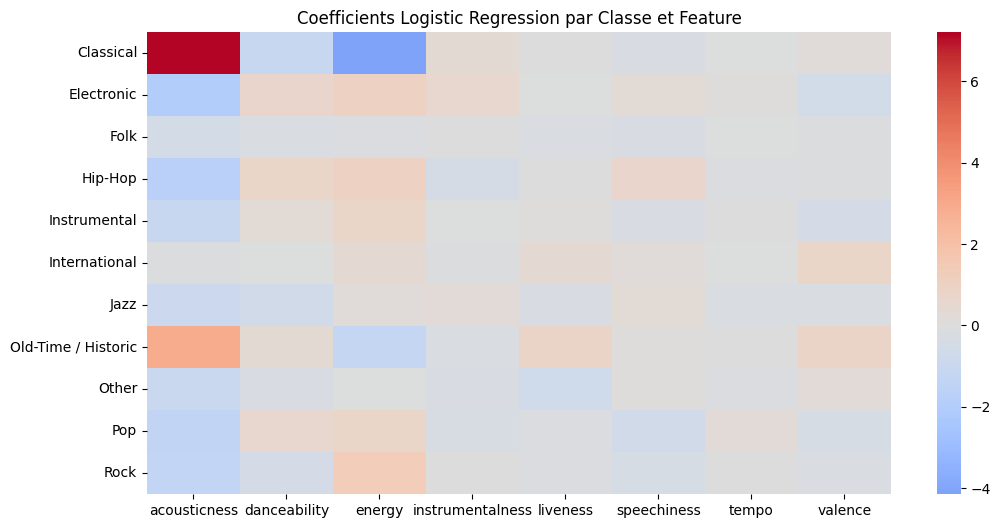

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap des coefficients
plt.figure(figsize=(12,6))
sns.heatmap(coef_df, cmap='coolwarm', center=0)
plt.title("Coefficients Logistic Regression par Classe et Feature")
plt.show()